# Imports section

In [3]:
import numpy as np
import os
from datasets import load_dataset
from PIL import Image, ImageDraw

/home/szczepan/miniconda3/envs/computer_vision/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# !pip install -U -q datasets transformers[torch] timm wandb torchmetrics matplotlib albumentations

# Read data

I will use this car plates dataset:

@misc{ vehicle-registration-plates-trudk_dataset,
    title = { Vehicle Registration Plates Dataset },
    type = { Open Source Dataset },
    author = { Augmented Startups },
    howpublished = { \\url{ https://universe.roboflow.com/augmented-startups/vehicle-registration-plates-trudk } },
    url = { https://universe.roboflow.com/augmented-startups/vehicle-registration-plates-trudk },
    journal = { Roboflow Universe },
    publisher = { Roboflow },
    year = { 2022 },
    month = { jun },
    note = { visited on 2023-01-18 },
}


The dataset is avaible on hugging face, so we can easy download the data.

In [5]:
ds = load_dataset("keremberke/license-plate-object-detection", "full")

In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 6176
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1765
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 882
    })
})

Dataset object contains splits for train / validation and test.
Lets split this datasets:

In [7]:
train_ds = ds["train"]
validation_ds = ds["validation"]
test_ds = ds["test"]

Here we can see one example from dataset. What it contains.

In [8]:
train_ds[0]

{'image_id': 6152,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 'width': 472,
 'height': 303,
 'objects': {'id': [6388],
  'area': [2604],
  'bbox': [[261.0, 203.0, 93.0, 28.0]],
  'category': [0]}}

#### The examples in the dataset have the following fields:

* **image_id**: the example image id
* **image**: a PIL.Image.Image object containing the image
* **width**: width of the image
* **height**: height of the image
* **objects**: a dictionary containing bounding box metadata for the objects in the image:
* **id**: the annotation id
* **area**: the area of the bounding box
* **bbox**: the object’s bounding box (in the [COCO](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/#coco) format )
    * => [x_min, y_min, width, height]. They are coordinates of the top-left corner along with the width and height of the bounding box.
* **category**: the object’s category, with possible values (in this case only one value category [0] minig plate but in another examples can be more)

In [9]:
train_ds.features

{'image_id': Value(dtype='int64', id=None),
 'image': Image(mode=None, decode=True, id=None),
 'width': Value(dtype='int32', id=None),
 'height': Value(dtype='int32', id=None),
 'objects': Sequence(feature={'id': Value(dtype='int64', id=None), 'area': Value(dtype='int64', id=None), 'bbox': Sequence(feature=Value(dtype='float32', id=None), length=4, id=None), 'category': ClassLabel(names=['license_plate'], id=None)}, length=-1, id=None)}

to seemply see image we can do:

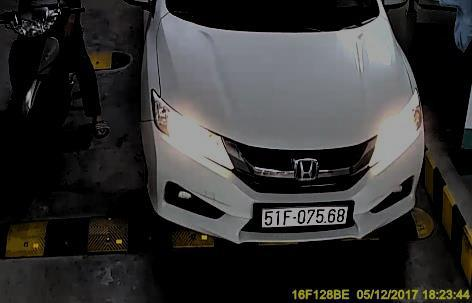

In [10]:
train_ds[0]["image"]

creating dictionaries with indexes and labales

In [11]:
categories = ds["train"].features["objects"].feature["category"].names
id2label = {index: x for index, x in enumerate(categories, start=0)}
label2id = {v: k for k, v in id2label.items()}

{'id': [6388], 'area': [2604], 'bbox': [[261.0, 203.0, 93.0, 28.0]], 'category': [0]}


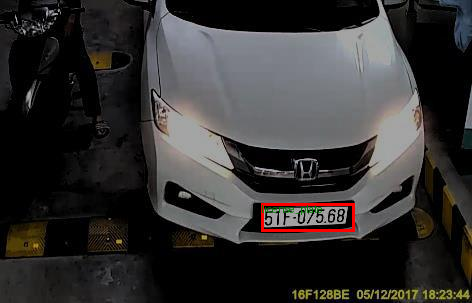

In [25]:
def draw_image_from_idx(dataset, idx, format="coco", draw_label=True):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    print(annotations)

    for i in range(len(annotations["id"])):
        box = annotations["bbox"][i]
        if format == "coco":
            x, y, w, h = tuple(box) 

            x_min, y_min = int(x), int(y)
            x_max, y_max = int(x + w), int(y + h)

        elif format == "yolo":
            x, y, w, h = tuple(box)

            # Konwersja YOLO -> (x_min, y_min, x_max, y_max)
            x_min = (x - w / 2)  
            y_min = (y - h / 2)  
            x_max = (x + w / 2)  
            y_max = (y + h / 2)  

        else:
            raise Exception("Chceck format of bboxes, if new format need to be implemented!!!")
        
        # in some cases coordinates can be normalized (yolo for example use that technicue), so to proper visialisation we need to re scale them
        if max(box) > 1.0:
            # Coordinates are un-normalized, no need to re-scale them
            pass
        else:
            # Coordinates are normalized, re-scale them
            x_min = int(x_min * width)
            y_min = int(y_min * height)
            x_max = int(x_max * width)
            y_max = int(y_max * height)
 
        draw.rectangle((x_min, y_min, x_max, y_max), outline="red", width=3)
        if draw_label:
            draw.text((x_min, y_min), id2label[annotations["category"][i]], fill="green")

    return image


draw_image_from_idx(dataset=train_ds, idx=0)  # You can test changing this id